<a href="https://colab.research.google.com/github/osamamalik234/DS-A/blob/main/Lab_11_20SW032.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-means Clustering of Movie Ratings

Say you're a data analyst at Netflix and you want to explore the similarities and differences in people's tastes in movies based on how they rate different movies. Can understanding these ratings contribute to a movie recommendation system for users? Let's dig into the data and see.

The data we'll be using comes from the wonderful [MovieLens](https://movielens.org/) [user rating dataset](https://grouplens.org/datasets/movielens/). We'll be looking at individual movie ratings later in the notebook, but let us start with how ratings of genres compare to each other.

## Dataset overview
The dataset has two files. We'll import them both into pandas dataframes:

In [ ]:
# Import the ratings dataset
movies = pd.read_csv('/content/movies.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# Import the ratings dataset
ratings = pd.read_csv('/content/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Now that we know the structure of our dataset, how many records do we have in each of these tables?

In [ ]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


## using helper.py file code

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)


def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Fantasy rating')
    ax.set_ylabel('Avg Comedy rating')


    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_fantasy_rating'], clustered['avg_comedy_rating'], c=clustered['group'], s=20, cmap=cmap)


def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)


def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    print(genre_ratings)
    genre_ratings.columns = column_names
    return genre_ratings

def get_dataset_3(movies, ratings, genre_ratings):
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_comedy_rating', 'avg_fanatsy_rating', 'avg_action_rating']

    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_comedy_rating'] < b1 - 0.2) & (genre_ratings_3['avg_fantasy_rating'] > b2)) | ((genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())

    return biased_dataset_3

def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg fantasy rating')
    ax.set_ylabel('Avg comedy rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_fantasy_rating'],
                        point['avg_comedy_rating'],
                        s=size,
                        color=color)

def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]

        d = sort_by_rating_density(d, max_movies, max_users)

        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)

            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off')
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)

    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_comedy_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_fantasy_rating'] > score_limit_2)) | ((genre_ratings['avg_fantasy_rating'] < score_limit_1) & (genre_ratings['avg_comedy_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset


## Comedy vs. Fantasy
Let's start by taking a subset of users, and seeing what their preferred genres are. We're hiding the most data preprocessing in helper functions so the focus is on the topic of clustering. It would be useful if you skim helper.py to see how these helper functions are implemented after finishing this notebook.

In [ ]:
# Calculate the average rating of romance and scifi movies

genre_ratings = get_genre_ratings(ratings, movies, ['Comedy', 'Fantasy'], ['avg_comedy_rating', 'avg_fantasy_rating'])
genre_ratings.head()

     rating  rating
1      2.00    2.12
2      3.09    3.40
3      3.61    3.00
4      4.33    4.57
5      3.98    3.75
..      ...     ...
668    3.44    4.00
669    3.40    3.00
670    3.86    3.33
671    3.81    4.41
446     NaN    4.72

[671 rows x 2 columns]


,avg_comedy_rating,avg_fantasy_rating
1,2.00,2.12
2,3.09,3.40
3,3.61,3.00
4,4.33,4.57
5,3.98,3.75


The function `get_genre_ratings` calculated each user's average rating of all romance movies and all scifi movies. Let's bias our dataset a little by removing people who like both scifi and romance, just so that our clusters tend to define them as liking one genre more than the other.

In [ ]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  164


,index,avg_comedy_rating,avg_fantasy_rating
0,3,3.61,3.00
1,6,2.91,3.69
2,12,2.71,2.00
3,14,3.00,2.75
4,15,2.54,2.15


So we can see we have 164 users, and for each user we have their average rating of the romance and sci movies they've watched.

Let us plot this dataset:

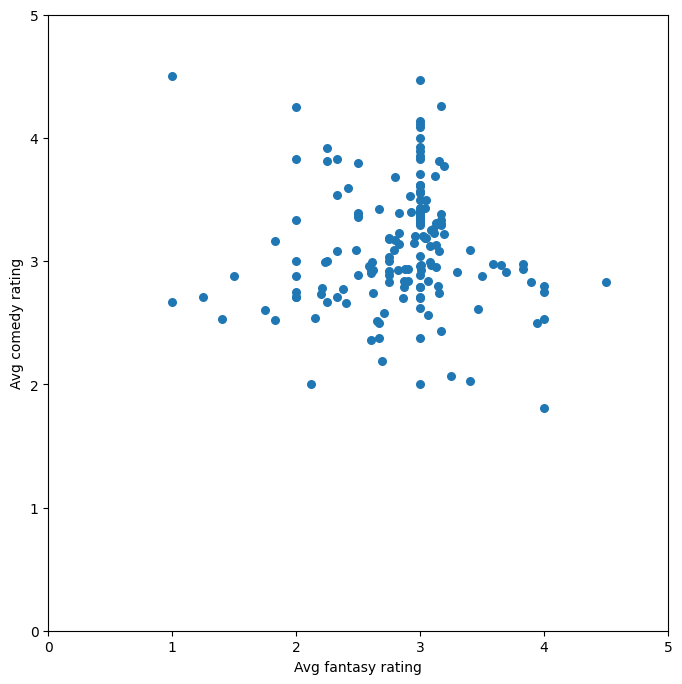

In [ ]:
%matplotlib inline

draw_scatterplot(biased_dataset['avg_fantasy_rating'],'Avg fantasy rating', biased_dataset['avg_comedy_rating'], 'Avg comedy rating')

We can see come clear bias in this sample (that we created on purpose). How would it look if we break the sample down into two groups using k-means?

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_fantasy_rating','avg_comedy_rating']].values

* Import [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* Prepare KMeans with n_clusters = 2
* Pass the dataset **X** to KMeans' fit_predict method and retrieve the clustering labels into *predictions*

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


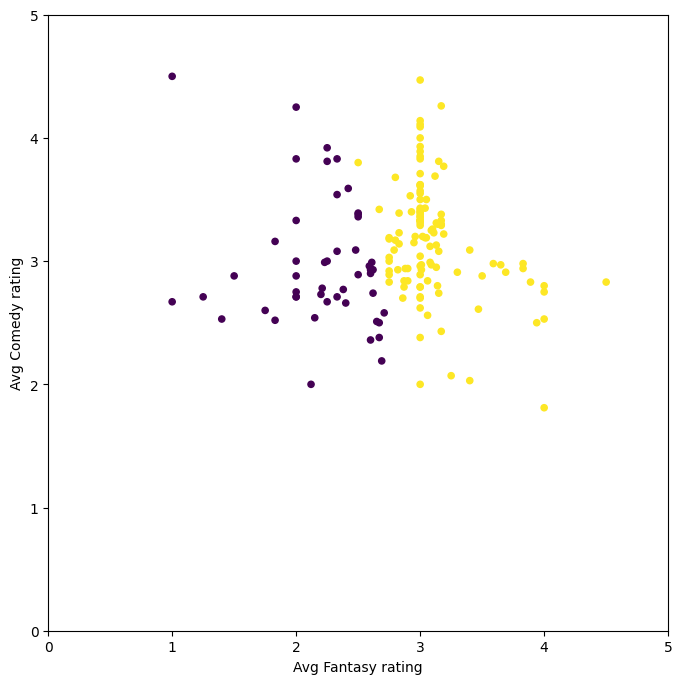

In [ ]:
# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions)

We can see that the groups are mostly based on how each person rated romance movies. If their average rating of romance movies is over 3 stars, then they belong to one group. Otherwise, they belong to the other group.

What would happen if we break them down into three groups?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


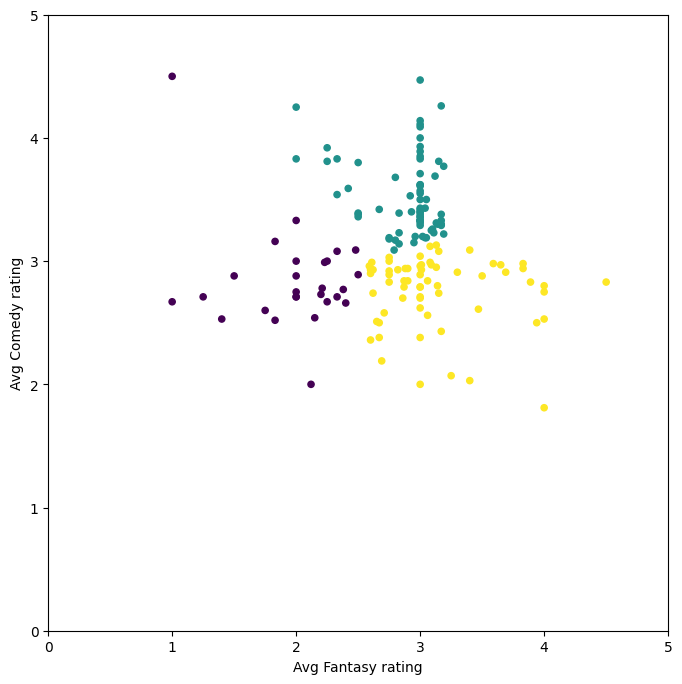

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions_2)

Now the average fantasy rating is starting to come into play. The groups are:
 * people who like comedy but not fantasy
 * people who like fantasy but not comedy
 * people who like both fantasy and comedy

Let's add one more group

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


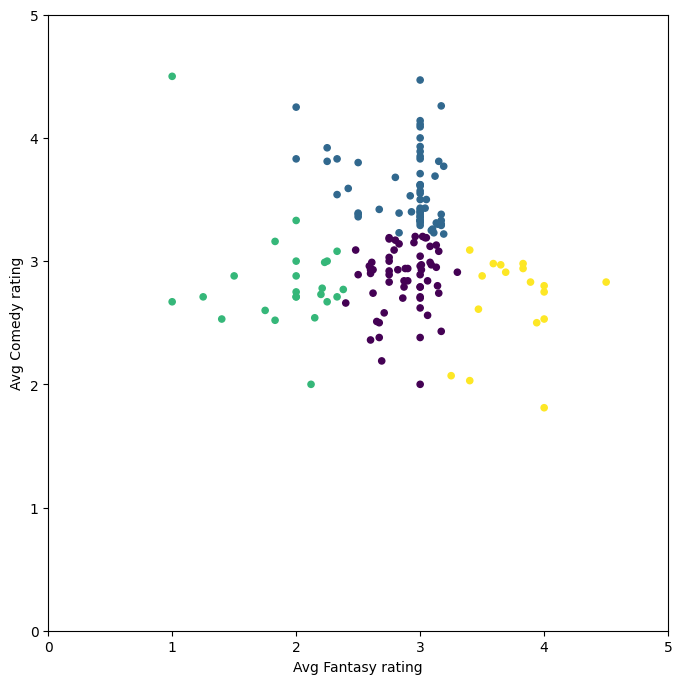

In [ ]:
# Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters=4)

# use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
draw_clusters(biased_dataset, predictions_3)

We can see that the more clusters we break our dataset down into, the more similar the tastes of the population of each cluster to each other.

## Choosing K
Great, so we can cluster our points into any number of clusters. What's the right number of clusters for this dataset?

There are [several](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) ways of choosing the number of clusters, k. We'll look at a simple one called "the elbow method". The elbow method works by plotting the ascending values of k versus the total error calculated using that k.

How do we calculate total error?
One way to calculate the error is squared error. Say we're calculating the error for k=2. We'd have two clusters each having one "centroid" point. For each point in our dataset, we'd subtract its coordinates from the centroid of the cluster it belongs to. We then square the result of that subtraction (to get rid of the negative values), and sum the values. This would leave us with an error value for each point. If we sum these error values, we'd get the total error for all points when k=2.

Our mission now is to do the same for each k (between 1 and, say, the number of elements in our dataset)

In [ ]:
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
# Optional: Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 0.37029677664468713),
 (7, 0.3869483087917922),
 (12, 0.4203106361032414),
 (17, 0.36889257513341533),
 (22, 0.3839167976103416),
 (27, 0.3947972511411032),
 (32, 0.40846169287076184),
 (37, 0.4100290818559728),
 (42, 0.41848786921965153),
 (47, 0.4207626600483343),
 (52, 0.3923186186840782),
 (57, 0.39891704674864004),
 (62, 0.41991740258156707),
 (67, 0.3903257581419279),
 (72, 0.40162287610977904),
 (77, 0.3982644878327775),
 (82, 0.38181425631050653),
 (87, 0.35294993934951774),
 (92, 0.35736208843939343),
 (97, 0.3627676717517858),
 (102, 0.3355992747919969),
 (107, 0.33733174129261334),
 (112, 0.3222917610505647),
 (117, 0.2941846231003543),
 (122, 0.28296313076812235),
 (127, 0.258312993447724),
 (132, 0.24871726546109255),
 (137, 0.2101042801609394),
 (142, 0.1857801637495682),
 (147, 0.1529909562200619),
 (152, 0.12125165912503649),
 (157, 0.08536571952736563),
 (162, 0.08536571952736563)]

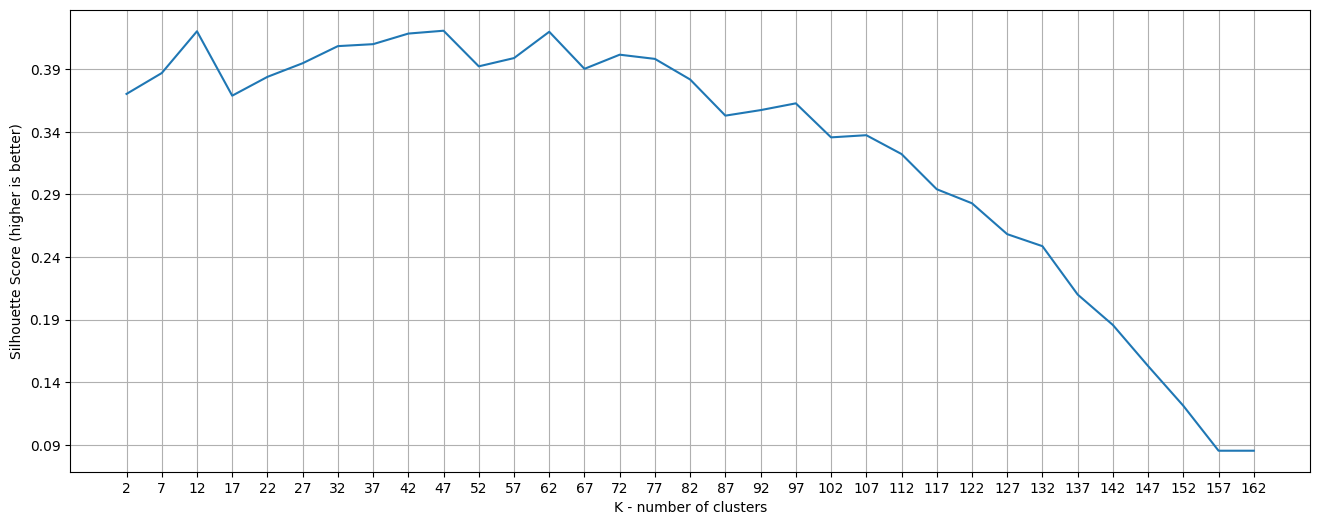

In [ ]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Looking at this graph, good choices for k include 7, 22, 27, 32, amongst other values (with a slight variation between different runs). Increasing the number of clusters (k) beyond that range starts to result in worse clusters (according to Silhouette score)

My pick would be k=7 because it's easier to visualize:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


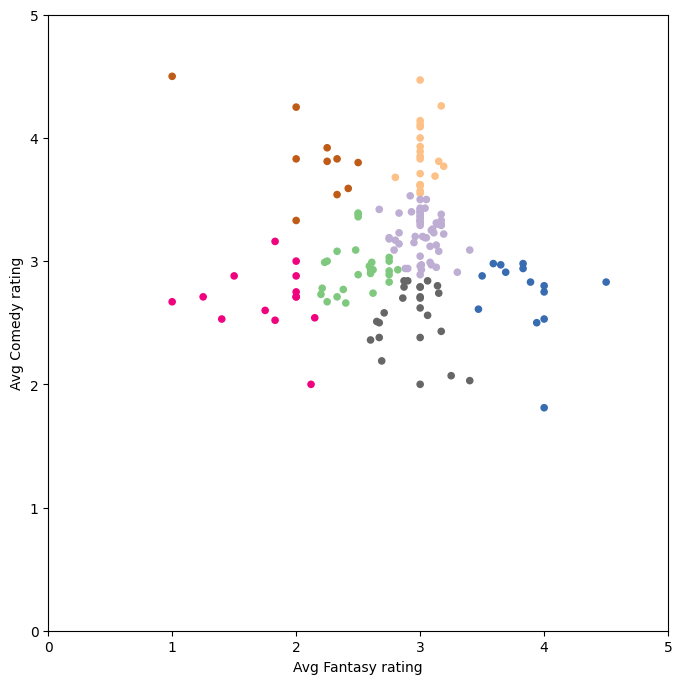

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

# use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Note: As you try to plot larger values of k (more than 10), you'll have to make sure your plotting library is not reusing colors between clusters. For this plot, we had to use the [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) 'Accent' because other colormaps either did not show enough contrast between colors, or were recycling colors past 8 or 10 clusters.


## Throwing some Action into the mix
So far, we've only been looking at how users rated romance and scifi movies. Let's throw another genre into the mix. Let's add the Action genre.

Our dataset now looks like this:

In [ ]:
biased_dataset_3_genres = get_genre_ratings(ratings, movies,
                                                     ['Comedy', 'Fantasy', 'Action'],
                                                     ['avg_comedy_rating', 'avg_fantasy_rating', 'avg_action_rating'])
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

     rating  rating  rating
1      2.00    2.12    2.80
2      3.09    3.40    3.32
3      3.61    3.00    3.47
4      4.33    4.57    4.27
5      3.98    3.75    4.00
..      ...     ...     ...
668    3.44    4.00    3.50
669    3.40    3.00    3.78
670    3.86    3.33    3.60
671    3.81    4.41    4.00
446     NaN    4.72    4.62

[671 rows x 3 columns]
Number of records:  164


,index,avg_comedy_rating,avg_fantasy_rating,avg_action_rating
0,3,3.61,3.00,3.47
1,6,2.91,3.69,3.27
2,12,2.71,2.00,3.21
3,14,3.00,2.75,2.86
4,15,2.54,2.15,2.48


In [ ]:
X_with_action = biased_dataset_3_genres[['avg_comedy_rating',
                                         'avg_fantasy_rating',
                                         'avg_action_rating']].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


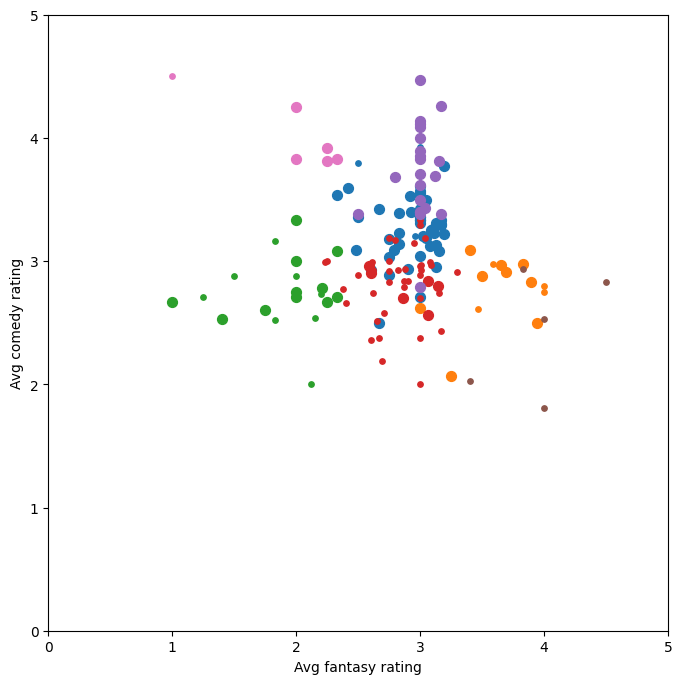

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

We're still using the x and y axes for scifi and romance respectively. We are using the size of the dot to roughly code the 'action' rating (large dot for avg ratings over than 3, small dot otherwise).

We can start seeing the added genre is changing how the users are clustered. The more data we give to k-means, the more similar the tastes of the people in each group would be. Unfortunately, though, we lose the ability to visualize what's going on past two or three dimensions if we continue to plot it this way. In the next section, we'll start using a different kind of plot to be able to see clusters with up to fifty dimensions.

## Movie-level Clustering
Now that we've established some trust in how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies. To do that, we'll shape the dataset in the form of userId vs user rating for each movie. For example, let's look at a subset of the dataset:

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called "sparse" because only a small number of cells have values.

To get around this, let's sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

If we're to choose the most-rated movies vs users with the most ratings, it would look like this:

In [ ]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


<ipython-input-2-5c3e6040c1e1>:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


That's more like it. Let's also establish a good way for visualizing these ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets.

Let's use colors instead of the number ratings:

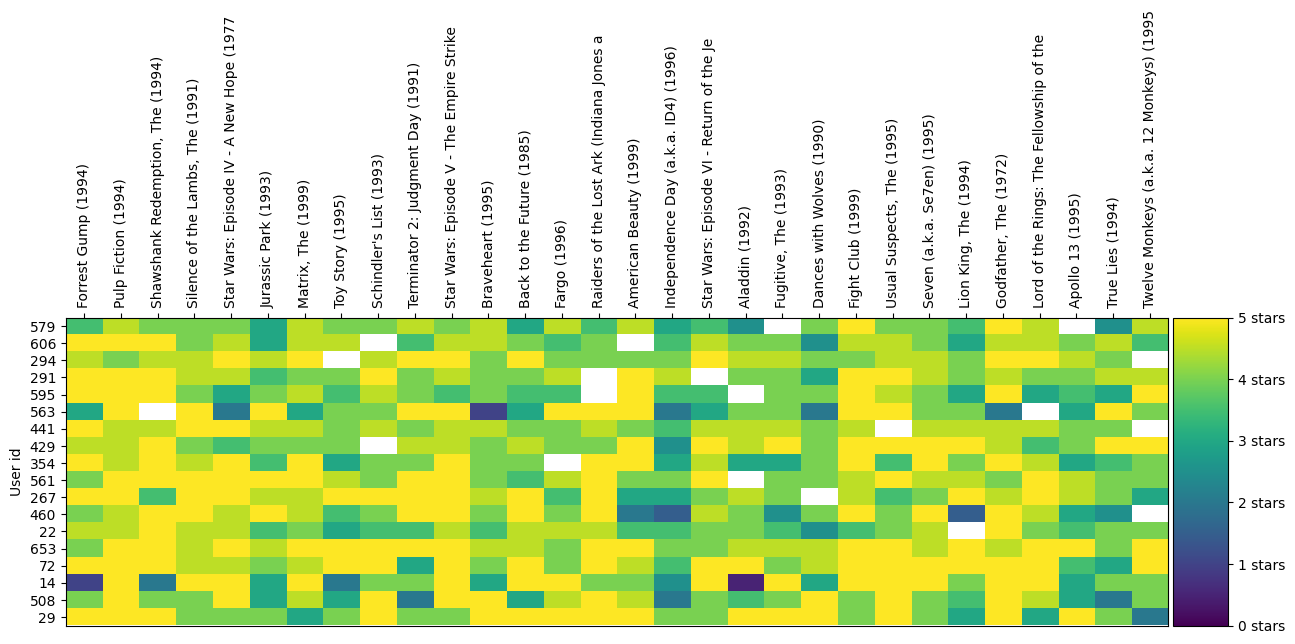

In [ ]:
draw_movies_heatmap(most_rated_movies_users_selection)

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

Notice how some cells are white? This means the respective user did not rate that movie. This is an issue you'll come across when clustering in real life. Unlike the clean example we started with, real-world datasets can often be sparse and not have a value in each cell of the dataset. This makes it less straightforward to cluster users directly by their movie ratings as k-means generally does not like missing values.

For performance reasons, we'll only use ratings for 1000 movies (out of the 9000+ available in the dataset).

In [ ]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

<ipython-input-2-5c3e6040c1e1>:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


To have sklearn run k-means clustering to a dataset with missing values like this, we will first cast it to the [sparse csr matrix](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.html) type defined in the SciPi library.

To convert from a pandas dataframe to a sparse matrix, we'll have to convert to SparseDataFrame, then use pandas' `to_coo()` method for the conversion.

Note: `to_coo()` was only added in later versions of pandas. If you run into an error with the next cell, make sure pandas is up to date.

In [ ]:
from scipy.sparse import coo_matrix

# Assuming most_rated_movies_1k is a DataFrame
sparse_ratings = coo_matrix(most_rated_movies_1k.values)

## Let's cluster!
With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 (A better way to pick k is as illustrated above with the elbow method. That would take some processing time to run, however.):

In [ ]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix

# Assuming sparse_ratings is a sparse matrix
imputer = SimpleImputer(strategy='constant', fill_value=0)
sparse_ratings_imputed = csr_matrix(imputer.fit_transform(sparse_ratings))

# Use K-means clustering
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings_imputed)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


To visualize some of these clusters, we'll plot each cluster as a heat map:

In [ ]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster.
* It's super interesting to spot trends in clusters:
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movoies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
 * Can you track where the Lord of the Rings movies appear in each cluster? What about Star Wars movies?
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. This is likely one of the reasons for Netflix switching from a stars-based ratings to a thumbs-up/thumbs-down rating. A rating of four stars means different things to different people.
* We did a few things to make the clusters visibile (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies).

## Prediction
Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

Let's first pick a cluster:

<ipython-input-2-5c3e6040c1e1>:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


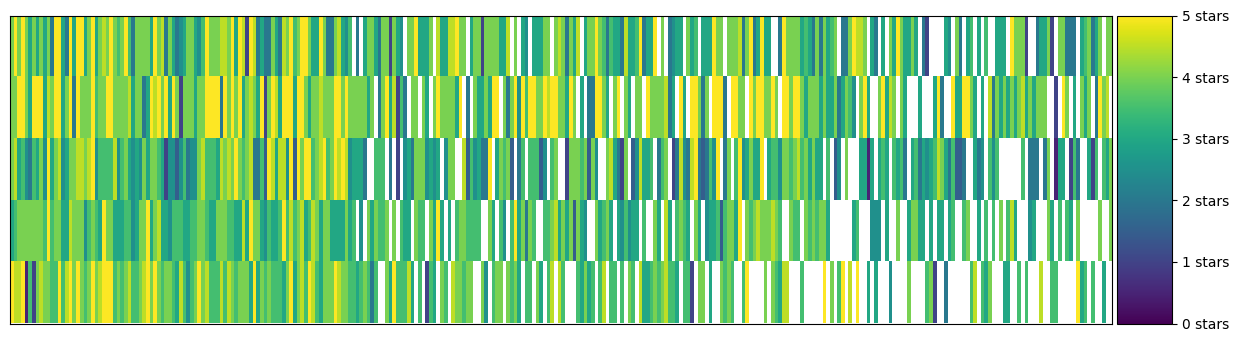

In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

And the actual ratings in the cluster look like this:

In [ ]:
cluster.fillna('').head()

,Forrest Gump (1994),Casablanca (1942),Rain Man (1988),"Big Lebowski, The (1998)","English Patient, The (1996)",Four Weddings and a Funeral (1994),"Insider, The (1999)",There's Something About Mary (1998),Trainspotting (1996),Interview with the Vampire: The Vampire Chronicles (1994),...,Falling Down (1993),Bob Roberts (1992),Gangs of New York (2002),Wonder Boys (2000),"Saint, The (1997)",Desperately Seeking Susan (1985),"Killing Fields, The (1984)",Hero (Ying xiong) (2002),Master and Commander: The Far Side of the World (2003),Sleepers (1996)
3,4.0,5.0,4.0,5.0,4.0,3.0,4.0,3.0,4.0,3.0,...,,3.0,3.5,4.0,2.0,3.0,4.0,,4.0,4.0
1,4.0,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,3.0,...,,4.0,3.0,4.0,,2.0,5.0,4.0,4.5,
2,4.0,4.5,3.0,3.5,2.5,2.0,3.5,3.0,4.0,2.5,...,2.0,,,3.0,1.0,3.5,,3.5,3.0,4.0
0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,...,4.0,,,,,,4.0,,,4.0
4,5.0,4.5,4.5,5.0,0.5,3.5,1.0,4.0,4.5,4.0,...,5.0,3.0,3.5,,3.5,,,3.0,,


Pick a blank cell from the table. It's blank because that user did not rate that movie. Can we predict whether she would like it or not? Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film.

In [ ]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
# Pick a movie from the table above since we're looking at a subset
movie_name = 'Terminator 2: Judgment Day (1991)'

cluster[movie_name].mean()

3.7

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset.


In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Forrest Gump (1994)                                               4.0
Casablanca (1942)                                                 4.3
Rain Man (1988)                                                   4.1
Big Lebowski, The (1998)                                          4.5
English Patient, The (1996)                                       3.0
Four Weddings and a Funeral (1994)                                3.1
Insider, The (1999)                                               3.5
There's Something About Mary (1998)                               3.8
Trainspotting (1996)                                              4.3
Interview with the Vampire: The Vampire Chronicles (1994)         3.2
L.A. Confidential (1997)                                          4.5
Ghost (1990)                                                      3.2
Being John Malkovich (1999)                                       4.3
Pulp Fiction (1994)                                               4.7
Home Alone (1990)   

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.


In [ ]:
# Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()"
# and pick one of the user ids (the first column in the table)
user_id = 1

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Scarface (1983)                             4.333333
Sleepers (1996)                             4.000000
Clockwork Orange, A (1971)                  4.000000
Exorcist, The (1973)                        4.000000
Lock, Stock & Two Smoking Barrels (1998)    4.000000
Femme Nikita, La (Nikita) (1990)            4.000000
Deer Hunter, The (1978)                     4.000000
American History X (1998)                   4.000000
Falling Down (1993)                         3.666667
Crying Game, The (1992)                     3.666667
Rounders (1998)                             3.625000
28 Days Later (2002)                        3.625000
Finding Nemo (2003)                         3.625000
Donnie Darko (2001)                         3.625000
Planes, Trains & Automobiles (1987)         3.500000
About a Boy (2002)                          3.500000
People vs. Larry Flynt, The (1996)          3.500000
Erin Brockovich (2000)                      3.500000
True Romance (1993)                         3.

And these are our top 20 recommendations to the user!

### Quiz:
 * If the cluster had a movie with only one rating. And that rating was 5 stars. What would the average rating of the cluster for that movie be? How does that effect our simple recommendation engine? How would you tweak the recommender to address this issue?

## More on Collaborative Filtering
* This is a simplistic recommendation engine that shows the most basic idea of "collaborative filtering". There are many heuristics and methods to improve it. [The Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) tried to push the envelope in this area by offering a prize of US$1,000,000 to the recommendation algorithm that shows the most improvement over Netflix's own recommendation algorithm.
* That prize was granted in 2009 to a team called "BellKor's Pragmatic Chaos". [This paper](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf) shows their approach which employed an ensemble of a large number of methods.
* [Netflix did not end up using this \$1,000,000 algorithm](https://thenextweb.com/media/2012/04/13/remember-netflixs-1m-algorithm-contest-well-heres-why-it-didnt-use-the-winning-entry/) because their switch to streaming gave them a dataset that's much larger than just movie ratings -- what searches did the user make? What other movies did the user sample in this session? Did they start watching a movie then stop and switch to a different movie? These new data points offered a lot more clues than the ratings alone.

## Take it Further

* This notebook showed user-level recommendations. We can actually use the almost exact code to do item-level recommendations. These are recommendations like Amazon's "Customers who bought (or viewed or liked) this item also bought (or viewed or liked)". These would be recommendations we can show on each movie's page in our app. To do this, we simple transpose the dataset to be in the shape of Movies X Users, and then cluster the movies (rather than the users) based on the correlation of their ratings.
* We used the smallest of the datasets Movie Lens puts out. It has 100,000 ratings. If you want to dig deeper in movie rating exploration, you can look at their [Full dataset](https://grouplens.org/datasets/movielens/) containing 24 million ratings.

